In [1]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from cinnamon.drift import ModelDriftExplainer, AdversarialDriftExplainer

RANDOM_SEED = 2021

# Boston Housing Data

In [2]:
boston = datasets.load_boston()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

In [3]:
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)

In [4]:
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [5]:
boston_df.shape

(506, 13)

# Build XGBoost model

In [6]:
X_train, X_test, y_train, y_test = train_test_split(boston_df, boston.target, test_size=0.3, random_state=RANDOM_SEED)

In [7]:
model = XGBRegressor(n_estimators=1000,
                   booster="gbtree",
                   objective="reg:squarederror",
                   learning_rate=0.05,
                   max_depth=6,
                   seed=RANDOM_SEED,
                   use_label_encoder=False)

In [8]:
model.fit(X=X_train, y=y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20, verbose=10)

[0]	validation_0-rmse:21.91000
[10]	validation_0-rmse:13.70702
[20]	validation_0-rmse:8.88745
[30]	validation_0-rmse:6.22773
[40]	validation_0-rmse:4.80921
[50]	validation_0-rmse:4.08774
[60]	validation_0-rmse:3.78189
[70]	validation_0-rmse:3.64388
[80]	validation_0-rmse:3.56963
[90]	validation_0-rmse:3.55412
[100]	validation_0-rmse:3.55249
[110]	validation_0-rmse:3.54351
[120]	validation_0-rmse:3.53571
[130]	validation_0-rmse:3.52958
[140]	validation_0-rmse:3.52470
[150]	validation_0-rmse:3.52710
[160]	validation_0-rmse:3.53023
[161]	validation_0-rmse:3.53167


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1,
             random_state=2021, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=2021, subsample=1, tree_method='exact',
             use_label_encoder=False, validate_parameters=1, verbosity=None)

# ModelDriftExplainer

The experiment is done with a random split so we should not detect a data drift

In [9]:
drift_explainer = ModelDriftExplainer(model)

In [10]:
drift_explainer.fit(X_train, X_test, y_train, y_test)

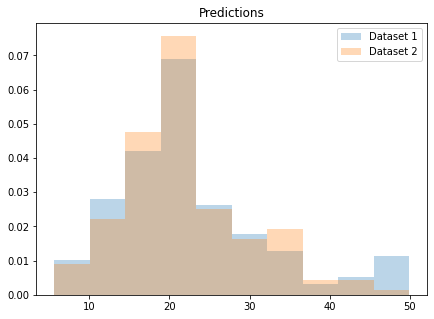

[DriftMetricsNum(mean_difference=-0.7889487954289152, wasserstein=1.0808420273082935, ks_test=BaseStatisticalTestResult(statistic=0.052743086529884034, pvalue=0.9096081584010307))]

In [11]:
# no apparent drift in distributions of predictions
drift_explainer.plot_prediction_drift()
drift_explainer.get_prediction_drift()

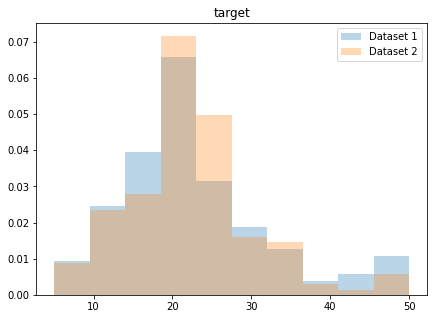

DriftMetricsNum(mean_difference=-0.609240261671129, wasserstein=1.3178114778471604, ks_test=BaseStatisticalTestResult(statistic=0.07857567647933393, pvalue=0.49680300786363996))

In [12]:
# no apparent drift in distributions of target labels
drift_explainer.plot_target_drift()
drift_explainer.get_target_drift()

In [13]:
# here we would detect a data drift but the difference in performance metrics
# is due to comparing train and test dataset
drift_explainer.get_performance_metrics_drift()

PerformanceMetricsDrift(dataset1=RegressionMetrics(mse=0.3643813701486243, explained_variance=0.9960752192224699), dataset2=RegressionMetrics(mse=12.419719495108291, explained_variance=0.8095694395593922))

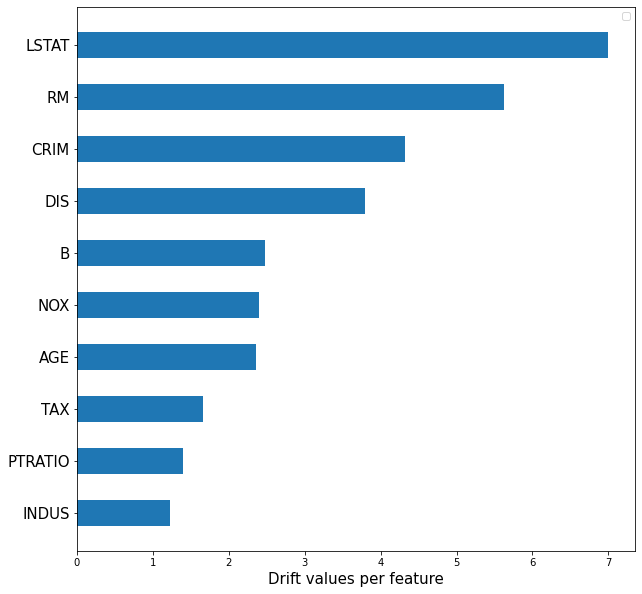

array([[4.31765569],
       [0.53994982],
       [1.2299105 ],
       [0.05466186],
       [2.40478511],
       [5.62793724],
       [2.3531374 ],
       [3.78890353],
       [0.73237733],
       [1.65802895],
       [1.39955313],
       [2.47726252],
       [6.99832357]])

In [14]:
# plot drift values computed with the tree based approach
drift_explainer.plot_tree_based_drift_values(type='node_size')
drift_explainer.get_tree_based_drift_values(type='node_size')

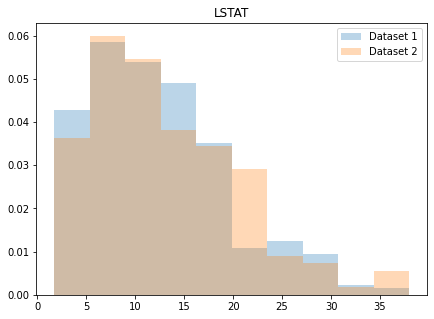

DriftMetricsNum(mean_difference=0.7378638864109419, wasserstein=0.8023078352661315, ks_test=BaseStatisticalTestResult(statistic=0.08887154326494201, pvalue=0.3452770147763935))

In [15]:
# no apparent drift for LSTAT the first feature indicated by drift values
drift_explainer.plot_feature_drift('LSTAT')
drift_explainer.get_feature_drift('LSTAT')

In [16]:
drift_explainer.get_feature_drift(0)

DriftMetricsNum(mean_difference=-1.1253475613291695, wasserstein=1.1305975918079103, ks_test=BaseStatisticalTestResult(statistic=0.0618123699078204, pvalue=0.7813257636577193))

In [17]:
drift_explainer.get_feature_drifts()

[DriftMetricsNum(mean_difference=-1.1253475613291695, wasserstein=1.1305975918079103, ks_test=BaseStatisticalTestResult(statistic=0.0618123699078204, pvalue=0.7813257636577193)),
 DriftMetricsNum(mean_difference=-0.7548691644365135, wasserstein=0.8747398156407966, ks_test=BaseStatisticalTestResult(statistic=0.02951234017246506, pvalue=0.9999448615410186)),
 DriftMetricsNum(mean_difference=-0.17914585191793364, wasserstein=0.7212444246208749, ks_test=BaseStatisticalTestResult(statistic=0.07381801962533452, pvalue=0.5764298225321839)),
 DriftMetricsNum(mean_difference=0.02337942313410645, wasserstein=0.02337942313410646, ks_test=BaseStatisticalTestResult(statistic=0.02337942313410645, pvalue=0.999999898017734)),
 DriftMetricsNum(mean_difference=-0.010584444692238959, wasserstein=0.01748104742789176, ks_test=BaseStatisticalTestResult(statistic=0.07296312815938151, pvalue=0.5907168134992116)),
 DriftMetricsNum(mean_difference=-0.015463871543265562, wasserstein=0.07063187630092177, ks_test=

# AdversarialDriftExplainer

In [18]:
# logs corresponds training logs of adversarial classifiers
drift_explainer2 = AdversarialDriftExplainer(seed=RANDOM_SEED).fit(X_train, X_test, y_train, y_test)

[0]	validation_0-error:0.48429	validation_0-auc:0.52346	validation_0-logloss:0.69203
[10]	validation_0-error:0.47734	validation_0-auc:0.56764	validation_0-logloss:0.68569
[20]	validation_0-error:0.47924	validation_0-auc:0.54122	validation_0-logloss:0.70776
[26]	validation_0-error:0.47342	validation_0-auc:0.53103	validation_0-logloss:0.72691
[0]	validation_0-error:0.56750	validation_0-auc:0.42686	validation_0-logloss:0.69947
[10]	validation_0-error:0.52141	validation_0-auc:0.47383	validation_0-logloss:0.73774
[19]	validation_0-error:0.53061	validation_0-auc:0.47215	validation_0-logloss:0.78257


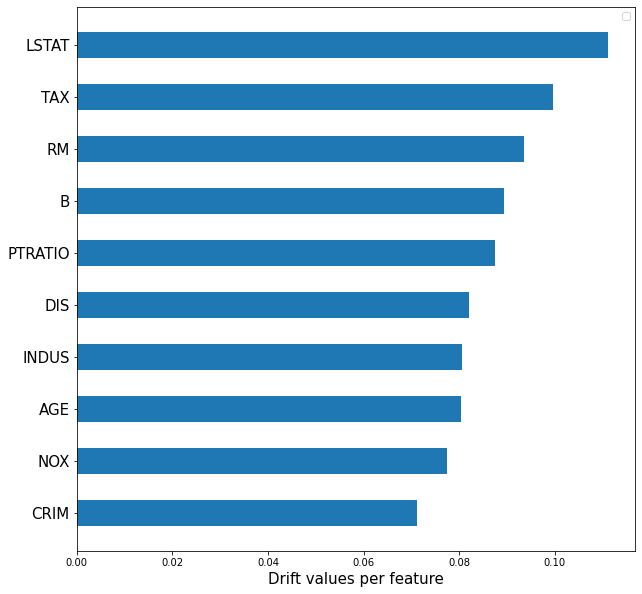

array([[0.07121204],
       [0.05696044],
       [0.08059485],
       [0.        ],
       [0.07737572],
       [0.09355285],
       [0.08030602],
       [0.08211254],
       [0.07022396],
       [0.09968404],
       [0.08741129],
       [0.08935069],
       [0.1112155 ]], dtype=float32)

In [19]:
# plot drift values computed with the adversarial approach
drift_explainer2.plot_adversarial_drift_values()
drift_explainer2.get_adversarial_drift_values()

In [20]:
drift_explainer2.get_feature_drifts()

[DriftMetricsNum(mean_difference=-1.1253475613291695, wasserstein=1.1305975918079103, ks_test=BaseStatisticalTestResult(statistic=0.0618123699078204, pvalue=0.7813257636577193)),
 DriftMetricsNum(mean_difference=-0.7548691644365135, wasserstein=0.8747398156407966, ks_test=BaseStatisticalTestResult(statistic=0.02951234017246506, pvalue=0.9999448615410186)),
 DriftMetricsNum(mean_difference=-0.17914585191793364, wasserstein=0.7212444246208749, ks_test=BaseStatisticalTestResult(statistic=0.07381801962533452, pvalue=0.5764298225321839)),
 DriftMetricsNum(mean_difference=0.02337942313410645, wasserstein=0.02337942313410646, ks_test=BaseStatisticalTestResult(statistic=0.02337942313410645, pvalue=0.999999898017734)),
 DriftMetricsNum(mean_difference=-0.010584444692238959, wasserstein=0.01748104742789176, ks_test=BaseStatisticalTestResult(statistic=0.07296312815938151, pvalue=0.5907168134992116)),
 DriftMetricsNum(mean_difference=-0.015463871543265562, wasserstein=0.07063187630092177, ks_test=

In [21]:
drift_explainer2.get_feature_drift('LSTAT')

DriftMetricsNum(mean_difference=0.7378638864109419, wasserstein=0.8023078352661315, ks_test=BaseStatisticalTestResult(statistic=0.08887154326494201, pvalue=0.3452770147763935))

In [22]:
drift_explainer2.get_feature_drift(0)

DriftMetricsNum(mean_difference=-1.1253475613291695, wasserstein=1.1305975918079103, ks_test=BaseStatisticalTestResult(statistic=0.0618123699078204, pvalue=0.7813257636577193))